In [40]:
import pandas as pd 

from sklearn.model_selection import train_test_split
import lightgbm as lgb
import optuna
from sklearn import metrics 

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor





In [8]:
data

,id,Hardness
0,10407,4.647
1,10408,4.647
2,10409,4.647
3,10410,4.647
4,10411,4.647
...,...,...
6934,17341,4.647
6935,17342,4.647
6936,17343,4.647
6937,17344,4.647


In [4]:
data = pd.read_csv("/kaggle/input/playground-series-s3e25/sample_submission.csv")
data.describe()

,id,Hardness
count,6939.000000,6.939000e+03
mean,13876.000000,4.647000e+00
std,2003.261091,8.882424e-16
min,10407.000000,4.647000e+00
25%,12141.500000,4.647000e+00
50%,13876.000000,4.647000e+00
75%,15610.500000,4.647000e+00
max,17345.000000,4.647000e+00


In [5]:
data.isnull().sum()

id          0
Hardness    0
dtype: int64

In [9]:
x = "/kaggle/input/playground-series-s3e25/train.csv"
train = pd.read_csv(x)
train

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10402,10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8
10405,10405,38.0,1.553160,12.666667,4.666667,26.621687,11.290033,2.743333,1.756667,0.980000,0.486507,0.77755,6.0


In [10]:
train.isnull().sum()

id                       0
allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

In [17]:
x = train.drop("Hardness", axis="columns")
y = train["Hardness"]


x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.9)

In [27]:
print(f"Val set: {round(x_val.shape[0] * 100 / x.shape[0], 0)}%")
print(f"Train set: {round(x_train.shape[0] * 100 / x.shape[0], 0)}%")

Val set: 10.0%
Train set: 90.0%


In [44]:
def objective(trial):
    model_type = trial.suggest_categorical("model_type", ["LinReg", "DT", "LGBM"])
    
    if model_type == "LinReg":
        model = LinearRegression()
    elif model_type == "DT":
        max_depth = trial.suggest_int("max_depth", 3, 8)
        model = DecisionTreeRegressor(max_depth=max_depth)
    elif model_type == "LGBM":
        params = {
            'objective': 'mse',
            'n_estimators': trial.suggest_int("n_estimators", 10, 30),
            'verbose': -1,
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True)
        }
        model = lgb.LGBMRegressor(**params)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    r2 = metrics.r2_score(y_val, y_pred)
    
    return r2

In [45]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2024-07-18 13:21:20,773] A new study created in memory with name: no-name-0c3e061f-4398-4e6f-880d-1fdf4ba192ff
[I 2024-07-18 13:21:20,831] Trial 0 finished with value: 0.43235447801774907 and parameters: {'model_type': 'LGBM', 'n_estimators': 18, 'boosting_type': 'gbdt', 'lambda_l1': 7.534424168325715e-05, 'lambda_l2': 4.054330554646063e-06}. Best is trial 0 with value: 0.43235447801774907.
[I 2024-07-18 13:21:20,872] Trial 1 finished with value: 0.3688129477775074 and parameters: {'model_type': 'DT', 'max_depth': 6}. Best is trial 0 with value: 0.43235447801774907.
[I 2024-07-18 13:21:20,914] Trial 2 finished with value: 0.3496023771109893 and parameters: {'model_type': 'LGBM', 'n_estimators': 10, 'boosting_type': 'dart', 'lambda_l1': 0.005961339494726436, 'lambda_l2': 7.915053249987216e-07}. Best is trial 0 with value: 0.43235447801774907.
[I 2024-07-18 13:21:20,940] Trial 3 finished with value: 0.22533175828605323 and parameters: {'model_type': 'LinReg'}. Best is trial 0 with val

In [47]:
study.best_params

{'model_type': 'LGBM',
 'n_estimators': 29,
 'boosting_type': 'gbdt',
 'lambda_l1': 2.132430429821647,
 'lambda_l2': 0.0002703780590608706}

In [46]:
study.best_value

0.45453340203099524

In [53]:
test

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.360000,5.280000,82.561240,9.370384,2.298000,1.907200,1.200000,0.461899,1.79459
1,10408,90.0,9.931960,18.000000,5.600000,39.568056,12.086300,2.868000,1.652000,0.864000,0.476196,1.41194
2,10409,116.0,7.767992,11.600000,4.800000,23.231818,11.023840,2.644000,1.794000,0.960000,0.499514,0.78834
3,10410,100.0,9.107996,10.000000,4.800000,20.298893,12.086300,2.828000,1.662000,0.792000,0.495796,1.20466
4,10411,55.0,4.030000,11.000000,4.000000,22.977675,11.280950,2.455000,1.750000,0.893333,0.476095,0.93456
...,...,...,...,...,...,...,...,...,...,...,...,...
6934,17341,446.0,36.135392,9.636364,4.636364,19.689448,11.045515,2.768636,1.769697,0.871818,0.498702,0.11548
6935,17342,36.0,3.550000,18.000000,4.000000,36.068500,8.236600,1.790000,2.055000,1.390000,0.499000,1.35045
6936,17343,68.0,4.545328,11.333333,5.333333,22.688853,10.938358,2.876667,1.713333,0.916667,0.499074,0.73425
6937,17344,40.0,2.334164,6.666667,4.000000,13.016128,12.700467,2.770000,1.476667,0.616667,0.663797,0.51227


In [57]:
x_test = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv")

y_test = pd.read_csv("/kaggle/input/playground-series-s3e25/sample_submission.csv")
y_test = y_test.drop("id", axis="columns")

In [58]:
best_params = study.best_params

model = lgb.LGBMRegressor(**best_params,
                          objective = 'mse',
                          n_estimator = 100,
                          verbose=-1)

model.fit(x_train, y_train,
          eval_set=[(x_test, y_test), (x_train, y_train)],
          eval_metric='mae')

LGBMRegressor(lambda_l1=2.132430429821647, lambda_l2=0.0002703780590608706,
              model_type='LGBM', n_estimator=100, n_estimators=29,
              objective='mse', verbose=-1)

In [59]:

def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [62]:

all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(x_train))
all_metrics["test"] = get_metrics(y_test, model.predict(x_test))
all_metrics["val"] = get_metrics(y_val, model.predict(x_val))

all_metrics

,train,test,val
MAE,0.88,9.300000e-01,0.94
RMSE,1.16,1.070000e+00,1.21
R2,0.53,-1.447095e+30,0.45


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

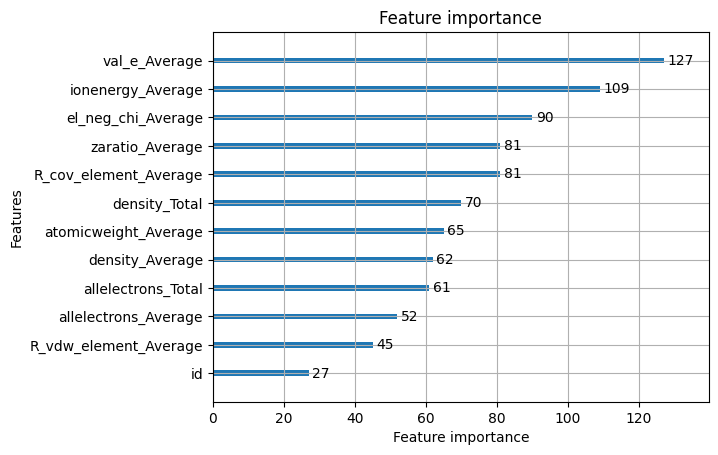

In [63]:
lgb.plot_importance(model)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

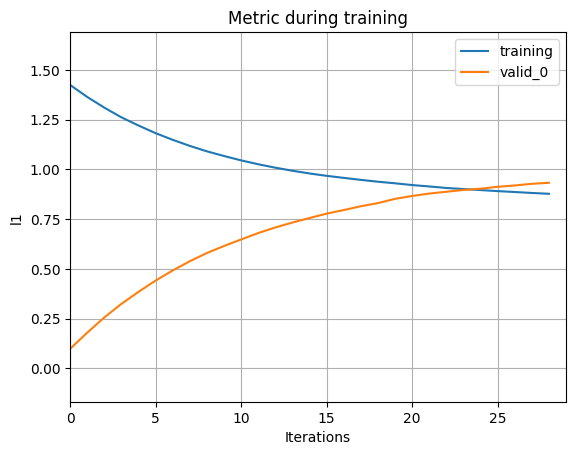

In [64]:

lgb.plot_metric(model,
                metric='l1')